# Conditional Denoising Diffusion Probabilistic Models (DDPMs) with fastai
By Tanishq Abraham and Thomas Capelle

In this notebook, we will implement [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

A one-sentence summary: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample conditioned to the label of the image.

The final model is capable to generate an image form a label!

Let's get started with the implementation!

## Imports

Here are all our imports. The unet file is taken from [lucidrains' DDPM implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) just to focus on implementing the training process rather than architectural details.

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from copy import deepcopy
# from data import *

## Dataloading

Let's load our data. We'll work with the famous MNIST dataset.

In [4]:
bs = 512 # batch size
size = 32 # image size
epochs = 500

In [5]:
path = untar_data(URLs.CIFAR)

We use the highly flexible DataBlock API in fastai to create our DataLoaders.

~~Note that we start with pure noise, generated with the obviously named `generate_noise` function.~~

Let's use a labelled dataset and train a conditional model on the label

In [6]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock()),
                   get_items = get_image_files,
                   get_y = lambda p: p.parent.name,
                   splitter = IndexSplitter(range(bs)),
                   item_tfms=Resize(size), 
                   batch_tfms = Normalize.from_stats(0.5, 0.5))

In [7]:
dls = dblock.dataloaders(path, bs=bs)

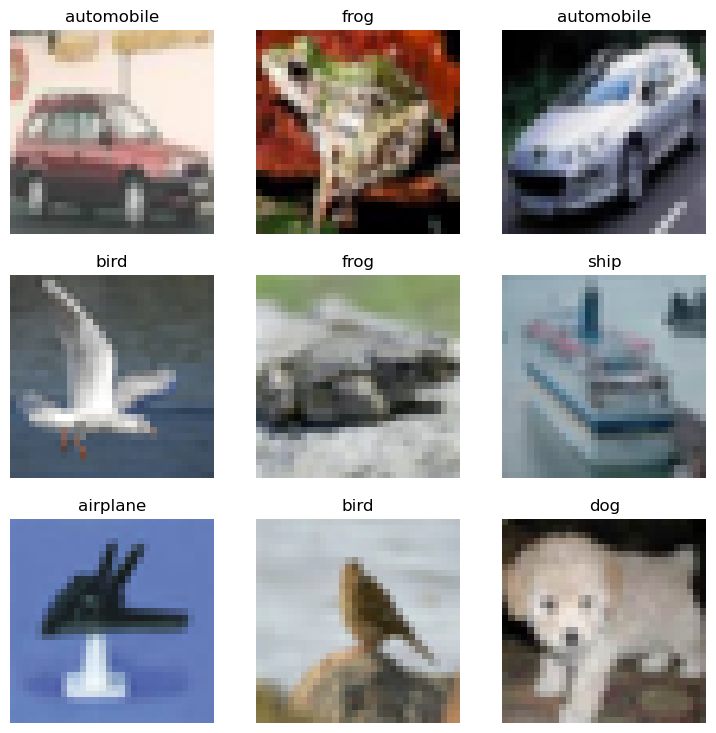

In [8]:
xb, yb = dls.one_batch()
dls.show_batch()

In [9]:
xb.max(), xb.min(), xb.mean(), xb.std()

(TensorImage(1., device='cuda:0'),
 TensorImage(-1., device='cuda:0'),
 TensorImage(-0.0538, device='cuda:0'),
 TensorImage(0.5074, device='cuda:0'))

## Conditional DDPM Training as a Callback

Same as DDPM callback but:
- We invert the x,y structure of the original callback
- Generates noise on the callback for the whole batch
- The sampling "before_batch_sampling" is done with labels that are fixed to [0,1,2,3,4...9,0,1,2,3....]

In [10]:
class ConditionalDDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max, cfg_scale=0):
        store_attr()
        self.tensor_type=TensorImage

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)
    
    def sample_timesteps(self, x, dtype=torch.long):
        return torch.randint(self.n_steps, (x.shape[0],), device=x.device, dtype=dtype)
    
    def generate_noise(self, x):
        return self.tensor_type(torch.randn_like(x))
    
    def noise_image(self, x, eps, t):
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        return torch.sqrt(alpha_bar_t)*x + torch.sqrt(1-alpha_bar_t)*eps # noisify the image
    
    def before_batch_training(self):
        x0 = self.xb[0] # original images and labels
        y0 =  self.yb[0] if np.random.random() > 0.1 else None
        
        # y0 = None
        
        eps = self.generate_noise(x0) # noise same shape as x0
        t =  self.sample_timesteps(x0) # select random timesteps
        xt =  self.noise_image(x0, eps, t)  # add noise to the image
        # print(x0.shape, y0.shape, t.shape, xt.shape, eps.shape)
        
        self.learn.xb = (xt, t, y0) # input to our model is noisy image, timestep and label
        self.learn.yb = (eps,) # ground truth is the noise 

    def sampling_algo(self, xt, t, label=None):
        t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
        alpha_t = self.alpha[t] # get noise level at current timestep
        alpha_bar_t = self.alpha_bar[t]
        sigma_t = self.sigma[t]
        alpha_bar_t_1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1, device=xt.device)
        beta_bar_t = 1 - alpha_bar_t
        beta_bar_t_1 = 1 - alpha_bar_t_1
        predicted_noise = self.model(xt, t_batch, label=label)
        if self.cfg_scale>0:
            uncond_predicted_noise = self.model(xt, t_batch, label=None)
            predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, self.cfg_scale)
        x0hat = (xt - torch.sqrt(beta_bar_t) * predicted_noise)/torch.sqrt(alpha_bar_t)
        x0hat = torch.clamp(x0hat, -1, 1)
        xt = x0hat * torch.sqrt(alpha_bar_t_1)*(1-alpha_t)/beta_bar_t + xt * torch.sqrt(alpha_t)*beta_bar_t_1/beta_bar_t + sigma_t*z 

        return xt
    
    # def sampling_algo_old(self, xt, t, label=None):
    #     t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
    #     z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
    #     alpha_t = self.alpha[t] # get noise level at current timestep
    #     alpha_bar_t = self.alpha_bar[t]
    #     sigma_t = self.sigma[t]
    #     xt = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.model(xt, t_batch, label=label)) + sigma_t*z 
    #          1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     # predict x_(t-1) in accordance to Algorithm 2 in paper
    #     return xt
    
    def sample(self):
        xt = self.generate_noise(self.xb[0]) # a full batch at once!
        label = torch.arange(10, dtype=torch.long, device=xt.device).repeat(xt.shape[0]//10 + 1).flatten()[0:xt.shape[0]]
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            xt = self.sampling_algo(xt, t, label) 
        return xt
    
    def before_batch_sampling(self):
        xt = self.sample()
        self.learn.pred = (xt,)
        raise CancelBatchException
    
    def after_validate(self):
        if (self.epoch+1) % 4 == 0:
            with torch.no_grad():
                xt = self.sample()
                wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})
    
    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()

In [11]:
class EMA(Callback):
    "Exponential Moving average CB"
    def __init__(self, beta=0.995, pct_start=0.3):
        store_attr()
        
    
    def before_fit(self):
        self.ema_model = deepcopy(self.model).eval().requires_grad_(False)
        self.step_start_ema = int(self.pct_start*self.n_epoch)  #start EMA at 30% of epochs
        
    def update_model_average(self):
        for current_params, ma_params in zip(self.model.parameters(), self.ema_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self):
        if self.epoch < self.step_start_ema:
            self.reset_parameters()
            self.step += 1
            return
        self.update_model_average()
        self.step += 1

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())
    
    def after_batch(self):
        if hasattr(self, 'pred'): return
        self.step_ema()
    
    def after_training(self):
        self.model = self.ema_model

We have to add the conditioning to the Unet, to do so, we just subclass it and inject the encoded label on the `forward` pass.

In [2]:
@delegates(Unet)
class ConditionalUnet(Unet):
    def __init__(self, dim, num_classes=None, **kwargs):
        super().__init__(dim=dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, dim * 4)
    
    def forward(self, x, time, label=None):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        if label is not None:
            t += self.label_emb(label)
            
        return super().forward_blocks(x, t)

Let's now initialize our model:

In [4]:
import torch

In [5]:
model = ConditionalUnet(dim=32, channels=1, num_classes=10)#.cuda()

torch.Size([1, 32, 1, 1286])


RuntimeError: Calculated padded input size per channel: (1 x 1286). Kernel size: (3 x 1). Kernel size can't be greater than actual input size

Now we can create a fastai Learner with our DataLoaders, Callback (with the appropriate number of timesteps and noise schedule) and the simple MSE loss that we use to train DDPM.

In [14]:
import wandb
from fastai.callback.wandb import WandbCallback

In [15]:
ddpm_learner = Learner(dls, model, 
                       cbs=[ConditionalDDPMCallback(n_steps=1000, beta_min=0.0001, beta_max=0.02, cfg_scale=3),
                            EMA()], 
                       loss_func=nn.MSELoss())

Let's use fastai's amazing LR finder to select a good LR for training:

In [16]:
# ddpm_learner.lr_find()

And now let's train with one-cycle LR schedule:

In [17]:
wandb.init(project="ddpm_fastai_mse", group="cifar10", tags=["fp", "ema"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geffenc2789 (geffenc). Use `wandb login --relogin` to force relogin


In [18]:
ddpm_learner.fit_one_cycle(epochs, 3e-4, cbs =[SaveModelCallback(monitor="train_loss", fname="cifar10"), 
                                               WandbCallback(log_preds=False, log_model=True)])

epoch,train_loss,valid_loss,time
0,0.908700,0.844862,00:30
1,0.699826,0.621994,00:28
2,0.521759,0.472878,00:28
3,0.386114,0.334766,02:46
4,0.288071,0.275902,00:28
5,0.220636,0.214948,00:28
6,0.176166,0.171682,00:28
7,0.145431,0.152217,02:46
8,0.125940,0.136175,00:28
9,0.107945,0.102888,00:28


Better model found at epoch 0 with train_loss value: 0.9087002873420715.
Better model found at epoch 1 with train_loss value: 0.6998255848884583.
Better model found at epoch 2 with train_loss value: 0.5217589139938354.


/tmp/ipykernel_3947841/1212810698.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})


Better model found at epoch 3 with train_loss value: 0.3861141502857208.


wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 463 is less than current step: 464. Dropping entry: {'epoch': 4, '_timestamp': 1712419006.2804108}).
wandb: WARNING (User provided step: 463 is less than current step: 464. Dropping entry: {'valid_loss': 0.33476588129997253, '_timestamp': 1712419006.280485}).


Better model found at epoch 4 with train_loss value: 0.2880712151527405.
Better model found at epoch 5 with train_loss value: 0.220635786652565.
Better model found at epoch 6 with train_loss value: 0.17616577446460724.


Better model found at epoch 7 with train_loss value: 0.1454312801361084.


wandb: WARNING (User provided step: 927 is less than current step: 928. Dropping entry: {'epoch': 8, '_timestamp': 1712419258.3208141}).
wandb: WARNING (User provided step: 927 is less than current step: 928. Dropping entry: {'valid_loss': 0.15221747756004333, '_timestamp': 1712419258.32091}).


Better model found at epoch 8 with train_loss value: 0.1259404867887497.
Better model found at epoch 9 with train_loss value: 0.10794533789157867.
Better model found at epoch 10 with train_loss value: 0.09407956153154373.


Better model found at epoch 11 with train_loss value: 0.08451348543167114.


wandb: WARNING (User provided step: 1391 is less than current step: 1392. Dropping entry: {'epoch': 12, '_timestamp': 1712419510.2247307}).
wandb: WARNING (User provided step: 1391 is less than current step: 1392. Dropping entry: {'valid_loss': 0.0931951254606247, '_timestamp': 1712419510.2248645}).


Better model found at epoch 12 with train_loss value: 0.07642581313848495.
Better model found at epoch 13 with train_loss value: 0.06896837800741196.
Better model found at epoch 14 with train_loss value: 0.06458374112844467.


Better model found at epoch 15 with train_loss value: 0.061650075018405914.


wandb: WARNING (User provided step: 1855 is less than current step: 1856. Dropping entry: {'epoch': 16, '_timestamp': 1712419763.4105942}).
wandb: WARNING (User provided step: 1855 is less than current step: 1856. Dropping entry: {'valid_loss': 0.0767616406083107, '_timestamp': 1712419763.4106948}).


Better model found at epoch 16 with train_loss value: 0.06017012149095535.
Better model found at epoch 17 with train_loss value: 0.05755919590592384.
Better model found at epoch 18 with train_loss value: 0.05650896579027176.


Better model found at epoch 19 with train_loss value: 0.055157843977212906.


wandb: WARNING (User provided step: 2319 is less than current step: 2320. Dropping entry: {'epoch': 20, '_timestamp': 1712420017.249391}).
wandb: WARNING (User provided step: 2319 is less than current step: 2320. Dropping entry: {'valid_loss': 0.061428919434547424, '_timestamp': 1712420017.2494893}).


Better model found at epoch 20 with train_loss value: 0.0546148382127285.
Better model found at epoch 21 with train_loss value: 0.053491923958063126.
Better model found at epoch 22 with train_loss value: 0.05302911251783371.


Better model found at epoch 23 with train_loss value: 0.05244413763284683.


wandb: WARNING (User provided step: 2783 is less than current step: 2784. Dropping entry: {'epoch': 24, '_timestamp': 1712420270.588297}).
wandb: WARNING (User provided step: 2783 is less than current step: 2784. Dropping entry: {'valid_loss': 0.06158444285392761, '_timestamp': 1712420270.5884004}).


Better model found at epoch 24 with train_loss value: 0.052077632397413254.
Better model found at epoch 25 with train_loss value: 0.051255661994218826.
Better model found at epoch 26 with train_loss value: 0.05094218626618385.


Better model found at epoch 27 with train_loss value: 0.05041829124093056.


wandb: WARNING (User provided step: 3247 is less than current step: 3248. Dropping entry: {'epoch': 28, '_timestamp': 1712420522.966887}).
wandb: WARNING (User provided step: 3247 is less than current step: 3248. Dropping entry: {'valid_loss': 0.060792580246925354, '_timestamp': 1712420522.9669979}).


Better model found at epoch 28 with train_loss value: 0.04904818907380104.


Better model found at epoch 31 with train_loss value: 0.04820700362324715.


wandb: WARNING (User provided step: 3711 is less than current step: 3712. Dropping entry: {'epoch': 32, '_timestamp': 1712420775.0726693}).
wandb: WARNING (User provided step: 3711 is less than current step: 3712. Dropping entry: {'valid_loss': 0.05299275368452072, '_timestamp': 1712420775.0727935}).


Better model found at epoch 32 with train_loss value: 0.047826968133449554.
Better model found at epoch 33 with train_loss value: 0.047229498624801636.
Better model found at epoch 34 with train_loss value: 0.04689481481909752.


Better model found at epoch 35 with train_loss value: 0.04669628664851189.


wandb: WARNING (User provided step: 4175 is less than current step: 4176. Dropping entry: {'epoch': 36, '_timestamp': 1712421027.7019005}).
wandb: WARNING (User provided step: 4175 is less than current step: 4176. Dropping entry: {'valid_loss': 0.053351156413555145, '_timestamp': 1712421027.701999}).


Better model found at epoch 36 with train_loss value: 0.04639839008450508.
Better model found at epoch 37 with train_loss value: 0.04590087756514549.
Better model found at epoch 38 with train_loss value: 0.04564587399363518.


Better model found at epoch 39 with train_loss value: 0.045439478009939194.


wandb: WARNING (User provided step: 4639 is less than current step: 4640. Dropping entry: {'epoch': 40, '_timestamp': 1712421281.4681907}).
wandb: WARNING (User provided step: 4639 is less than current step: 4640. Dropping entry: {'valid_loss': 0.06538817286491394, '_timestamp': 1712421281.4682975}).


Better model found at epoch 40 with train_loss value: 0.04469399154186249.
Better model found at epoch 42 with train_loss value: 0.043278422206640244.


wandb: WARNING (User provided step: 5103 is less than current step: 5104. Dropping entry: {'epoch': 44, '_timestamp': 1712421534.1658466}).
wandb: WARNING (User provided step: 5103 is less than current step: 5104. Dropping entry: {'valid_loss': 0.04838118702173233, '_timestamp': 1712421534.165942}).


Better model found at epoch 44 with train_loss value: 0.043157052248716354.
Better model found at epoch 45 with train_loss value: 0.04307832941412926.


Better model found at epoch 47 with train_loss value: 0.043012555688619614.


wandb: WARNING (User provided step: 5567 is less than current step: 5568. Dropping entry: {'epoch': 48, '_timestamp': 1712421786.4816804}).
wandb: WARNING (User provided step: 5567 is less than current step: 5568. Dropping entry: {'valid_loss': 0.04892928525805473, '_timestamp': 1712421786.4817882}).


Better model found at epoch 48 with train_loss value: 0.042521882802248.
Better model found at epoch 49 with train_loss value: 0.04238386079668999.
Better model found at epoch 50 with train_loss value: 0.04222459718585014.


Better model found at epoch 51 with train_loss value: 0.041341353207826614.


wandb: WARNING (User provided step: 6031 is less than current step: 6032. Dropping entry: {'epoch': 52, '_timestamp': 1712422039.6918392}).
wandb: WARNING (User provided step: 6031 is less than current step: 6032. Dropping entry: {'valid_loss': 0.046583857387304306, '_timestamp': 1712422039.6919632}).


Better model found at epoch 52 with train_loss value: 0.04099929332733154.
Better model found at epoch 54 with train_loss value: 0.040727224200963974.


wandb: WARNING (User provided step: 6495 is less than current step: 6496. Dropping entry: {'epoch': 56, '_timestamp': 1712422293.1035624}).
wandb: WARNING (User provided step: 6495 is less than current step: 6496. Dropping entry: {'valid_loss': 0.05136632174253464, '_timestamp': 1712422293.103675}).


Better model found at epoch 57 with train_loss value: 0.03984130918979645.


wandb: WARNING (User provided step: 6959 is less than current step: 6960. Dropping entry: {'epoch': 60, '_timestamp': 1712422545.6455865}).
wandb: WARNING (User provided step: 6959 is less than current step: 6960. Dropping entry: {'valid_loss': 0.043872617185115814, '_timestamp': 1712422545.6457026}).


Better model found at epoch 60 with train_loss value: 0.03974390774965286.
Better model found at epoch 61 with train_loss value: 0.039268530905246735.


Better model found at epoch 63 with train_loss value: 0.0388331338763237.


wandb: WARNING (User provided step: 7423 is less than current step: 7424. Dropping entry: {'epoch': 64, '_timestamp': 1712422798.0032241}).
wandb: WARNING (User provided step: 7423 is less than current step: 7424. Dropping entry: {'valid_loss': 0.042248427867889404, '_timestamp': 1712422798.0033314}).


Better model found at epoch 64 with train_loss value: 0.037969980388879776.


wandb: WARNING (User provided step: 7887 is less than current step: 7888. Dropping entry: {'epoch': 68, '_timestamp': 1712423050.1477034}).
wandb: WARNING (User provided step: 7887 is less than current step: 7888. Dropping entry: {'valid_loss': 0.04690698906779289, '_timestamp': 1712423050.1478133}).


Better model found at epoch 68 with train_loss value: 0.03729071095585823.


wandb: WARNING (User provided step: 8351 is less than current step: 8352. Dropping entry: {'epoch': 72, '_timestamp': 1712423304.141237}).
wandb: WARNING (User provided step: 8351 is less than current step: 8352. Dropping entry: {'valid_loss': 0.039328742772340775, '_timestamp': 1712423304.1413493}).


Better model found at epoch 75 with train_loss value: 0.03696276620030403.


wandb: WARNING (User provided step: 8815 is less than current step: 8816. Dropping entry: {'epoch': 76, '_timestamp': 1712423556.7744317}).
wandb: WARNING (User provided step: 8815 is less than current step: 8816. Dropping entry: {'valid_loss': 0.04028157889842987, '_timestamp': 1712423556.7745304}).


Better model found at epoch 76 with train_loss value: 0.0367981381714344.
Better model found at epoch 77 with train_loss value: 0.036576349288225174.
Better model found at epoch 78 with train_loss value: 0.03582630679011345.


wandb: WARNING (User provided step: 9279 is less than current step: 9280. Dropping entry: {'epoch': 80, '_timestamp': 1712423808.9331896}).
wandb: WARNING (User provided step: 9279 is less than current step: 9280. Dropping entry: {'valid_loss': 0.04143163561820984, '_timestamp': 1712423808.9332907}).


wandb: WARNING (User provided step: 9743 is less than current step: 9744. Dropping entry: {'epoch': 84, '_timestamp': 1712424062.6533494}).
wandb: WARNING (User provided step: 9743 is less than current step: 9744. Dropping entry: {'valid_loss': 0.044962719082832336, '_timestamp': 1712424062.6534479}).


Better model found at epoch 85 with train_loss value: 0.03543530032038689.
Better model found at epoch 86 with train_loss value: 0.035220880061388016.


wandb: WARNING (User provided step: 10207 is less than current step: 10208. Dropping entry: {'epoch': 88, '_timestamp': 1712424315.8866813}).
wandb: WARNING (User provided step: 10207 is less than current step: 10208. Dropping entry: {'valid_loss': 0.039697661995887756, '_timestamp': 1712424315.8868144}).


Better model found at epoch 89 with train_loss value: 0.03509903699159622.
Better model found at epoch 90 with train_loss value: 0.03492564335465431.


Better model found at epoch 91 with train_loss value: 0.03449861705303192.


wandb: WARNING (User provided step: 10671 is less than current step: 10672. Dropping entry: {'epoch': 92, '_timestamp': 1712424568.454747}).
wandb: WARNING (User provided step: 10671 is less than current step: 10672. Dropping entry: {'valid_loss': 0.04361487179994583, '_timestamp': 1712424568.4548569}).


Better model found at epoch 95 with train_loss value: 0.034252505749464035.


wandb: WARNING (User provided step: 11135 is less than current step: 11136. Dropping entry: {'epoch': 96, '_timestamp': 1712424820.8370621}).
wandb: WARNING (User provided step: 11135 is less than current step: 11136. Dropping entry: {'valid_loss': 0.03654778003692627, '_timestamp': 1712424820.8371768}).


Better model found at epoch 97 with train_loss value: 0.03399398550391197.


wandb: WARNING (User provided step: 11599 is less than current step: 11600. Dropping entry: {'epoch': 100, '_timestamp': 1712425074.263932}).
wandb: WARNING (User provided step: 11599 is less than current step: 11600. Dropping entry: {'valid_loss': 0.032322004437446594, '_timestamp': 1712425074.2640374}).


Better model found at epoch 103 with train_loss value: 0.033911652863025665.


wandb: WARNING (User provided step: 12063 is less than current step: 12064. Dropping entry: {'epoch': 104, '_timestamp': 1712425327.2662294}).
wandb: WARNING (User provided step: 12063 is less than current step: 12064. Dropping entry: {'valid_loss': 0.04202228784561157, '_timestamp': 1712425327.2663524}).


Better model found at epoch 104 with train_loss value: 0.033686790615320206.
Better model found at epoch 106 with train_loss value: 0.033281803131103516.


wandb: WARNING (User provided step: 12527 is less than current step: 12528. Dropping entry: {'epoch': 108, '_timestamp': 1712425579.808705}).
wandb: WARNING (User provided step: 12527 is less than current step: 12528. Dropping entry: {'valid_loss': 0.04732220992445946, '_timestamp': 1712425579.808816}).


wandb: WARNING (User provided step: 12991 is less than current step: 12992. Dropping entry: {'epoch': 112, '_timestamp': 1712425833.688859}).
wandb: WARNING (User provided step: 12991 is less than current step: 12992. Dropping entry: {'valid_loss': 0.036406442523002625, '_timestamp': 1712425833.6889827}).


Better model found at epoch 112 with train_loss value: 0.033153560012578964.


wandb: WARNING (User provided step: 13455 is less than current step: 13456. Dropping entry: {'epoch': 116, '_timestamp': 1712426087.220084}).
wandb: WARNING (User provided step: 13455 is less than current step: 13456. Dropping entry: {'valid_loss': 0.04242825135588646, '_timestamp': 1712426087.2201962}).


wandb: WARNING (User provided step: 13919 is less than current step: 13920. Dropping entry: {'epoch': 120, '_timestamp': 1712426339.8730457}).
wandb: WARNING (User provided step: 13919 is less than current step: 13920. Dropping entry: {'valid_loss': 0.04014473780989647, '_timestamp': 1712426339.8731654}).


Better model found at epoch 121 with train_loss value: 0.03294919803738594.


wandb: WARNING (User provided step: 14383 is less than current step: 14384. Dropping entry: {'epoch': 124, '_timestamp': 1712426593.2963831}).
wandb: WARNING (User provided step: 14383 is less than current step: 14384. Dropping entry: {'valid_loss': 0.04332753270864487, '_timestamp': 1712426593.296499}).


Better model found at epoch 126 with train_loss value: 0.032875556498765945.


Better model found at epoch 127 with train_loss value: 0.032818347215652466.


wandb: WARNING (User provided step: 14847 is less than current step: 14848. Dropping entry: {'epoch': 128, '_timestamp': 1712426846.1460347}).
wandb: WARNING (User provided step: 14847 is less than current step: 14848. Dropping entry: {'valid_loss': 0.04155576229095459, '_timestamp': 1712426846.1461406}).


Better model found at epoch 131 with train_loss value: 0.032393693923950195.


wandb: WARNING (User provided step: 15311 is less than current step: 15312. Dropping entry: {'epoch': 132, '_timestamp': 1712427098.5353308}).
wandb: WARNING (User provided step: 15311 is less than current step: 15312. Dropping entry: {'valid_loss': 0.03754499554634094, '_timestamp': 1712427098.5354748}).


Better model found at epoch 133 with train_loss value: 0.032322049140930176.


wandb: WARNING (User provided step: 15775 is less than current step: 15776. Dropping entry: {'epoch': 136, '_timestamp': 1712427352.2673392}).
wandb: WARNING (User provided step: 15775 is less than current step: 15776. Dropping entry: {'valid_loss': 0.035674307495355606, '_timestamp': 1712427352.267447}).


wandb: WARNING (User provided step: 16239 is less than current step: 16240. Dropping entry: {'epoch': 140, '_timestamp': 1712427606.5523927}).
wandb: WARNING (User provided step: 16239 is less than current step: 16240. Dropping entry: {'valid_loss': 0.04106679931282997, '_timestamp': 1712427606.5525134}).


Better model found at epoch 141 with train_loss value: 0.03208136186003685.
Better model found at epoch 142 with train_loss value: 0.03201121464371681.


wandb: WARNING (User provided step: 16703 is less than current step: 16704. Dropping entry: {'epoch': 144, '_timestamp': 1712427859.2089782}).
wandb: WARNING (User provided step: 16703 is less than current step: 16704. Dropping entry: {'valid_loss': 0.03641129285097122, '_timestamp': 1712427859.2090838}).


Better model found at epoch 147 with train_loss value: 0.03196856006979942.


wandb: WARNING (User provided step: 17167 is less than current step: 17168. Dropping entry: {'epoch': 148, '_timestamp': 1712428112.3929067}).
wandb: WARNING (User provided step: 17167 is less than current step: 17168. Dropping entry: {'valid_loss': 0.04126892611384392, '_timestamp': 1712428112.3930266}).


Better model found at epoch 151 with train_loss value: 0.03192448243498802.


wandb: WARNING (User provided step: 17631 is less than current step: 17632. Dropping entry: {'epoch': 152, '_timestamp': 1712428367.6839504}).
wandb: WARNING (User provided step: 17631 is less than current step: 17632. Dropping entry: {'valid_loss': 0.03205253556370735, '_timestamp': 1712428367.684072}).


Better model found at epoch 152 with train_loss value: 0.03182576224207878.


wandb: WARNING (User provided step: 18095 is less than current step: 18096. Dropping entry: {'epoch': 156, '_timestamp': 1712428620.481588}).
wandb: WARNING (User provided step: 18095 is less than current step: 18096. Dropping entry: {'valid_loss': 0.03338167816400528, '_timestamp': 1712428620.4817078}).


Better model found at epoch 157 with train_loss value: 0.03172873333096504.
Better model found at epoch 158 with train_loss value: 0.0316433347761631.


wandb: WARNING (User provided step: 18559 is less than current step: 18560. Dropping entry: {'epoch': 160, '_timestamp': 1712428874.4133103}).
wandb: WARNING (User provided step: 18559 is less than current step: 18560. Dropping entry: {'valid_loss': 0.03184285759925842, '_timestamp': 1712428874.4134412}).


wandb: WARNING (User provided step: 19023 is less than current step: 19024. Dropping entry: {'epoch': 164, '_timestamp': 1712429127.6298912}).
wandb: WARNING (User provided step: 19023 is less than current step: 19024. Dropping entry: {'valid_loss': 0.03482215106487274, '_timestamp': 1712429127.6300137}).


Better model found at epoch 165 with train_loss value: 0.03104216232895851.


wandb: WARNING (User provided step: 19487 is less than current step: 19488. Dropping entry: {'epoch': 168, '_timestamp': 1712429380.2176647}).
wandb: WARNING (User provided step: 19487 is less than current step: 19488. Dropping entry: {'valid_loss': 0.04154390096664429, '_timestamp': 1712429380.217779}).


wandb: WARNING (User provided step: 19951 is less than current step: 19952. Dropping entry: {'epoch': 172, '_timestamp': 1712429634.7442229}).
wandb: WARNING (User provided step: 19951 is less than current step: 19952. Dropping entry: {'valid_loss': 0.03808949887752533, '_timestamp': 1712429634.7443402}).


wandb: WARNING (User provided step: 20415 is less than current step: 20416. Dropping entry: {'epoch': 176, '_timestamp': 1712429887.7187462}).
wandb: WARNING (User provided step: 20415 is less than current step: 20416. Dropping entry: {'valid_loss': 0.038394585251808167, '_timestamp': 1712429887.7188544}).


wandb: WARNING (User provided step: 20879 is less than current step: 20880. Dropping entry: {'epoch': 180, '_timestamp': 1712430140.7054336}).
wandb: WARNING (User provided step: 20879 is less than current step: 20880. Dropping entry: {'valid_loss': 0.03155601769685745, '_timestamp': 1712430140.7055602}).


wandb: WARNING (User provided step: 21343 is less than current step: 21344. Dropping entry: {'epoch': 184, '_timestamp': 1712430394.6204486}).
wandb: WARNING (User provided step: 21343 is less than current step: 21344. Dropping entry: {'valid_loss': 0.040241092443466187, '_timestamp': 1712430394.6205618}).


wandb: WARNING (User provided step: 21807 is less than current step: 21808. Dropping entry: {'epoch': 188, '_timestamp': 1712430647.844909}).
wandb: WARNING (User provided step: 21807 is less than current step: 21808. Dropping entry: {'valid_loss': 0.03847065195441246, '_timestamp': 1712430647.8450077}).


wandb: WARNING (User provided step: 22271 is less than current step: 22272. Dropping entry: {'epoch': 192, '_timestamp': 1712430900.7807028}).
wandb: WARNING (User provided step: 22271 is less than current step: 22272. Dropping entry: {'valid_loss': 0.03495963662862778, '_timestamp': 1712430900.7808232}).


wandb: WARNING (User provided step: 22735 is less than current step: 22736. Dropping entry: {'epoch': 196, '_timestamp': 1712431155.0696938}).
wandb: WARNING (User provided step: 22735 is less than current step: 22736. Dropping entry: {'valid_loss': 0.03767000511288643, '_timestamp': 1712431155.0698333}).


wandb: WARNING (User provided step: 23199 is less than current step: 23200. Dropping entry: {'epoch': 200, '_timestamp': 1712431408.1825519}).
wandb: WARNING (User provided step: 23199 is less than current step: 23200. Dropping entry: {'valid_loss': 0.03423989564180374, '_timestamp': 1712431408.182664}).


wandb: WARNING (User provided step: 23663 is less than current step: 23664. Dropping entry: {'epoch': 204, '_timestamp': 1712431661.2163136}).
wandb: WARNING (User provided step: 23663 is less than current step: 23664. Dropping entry: {'valid_loss': 0.04145963490009308, '_timestamp': 1712431661.2164416}).


wandb: WARNING (User provided step: 24127 is less than current step: 24128. Dropping entry: {'epoch': 208, '_timestamp': 1712431915.7407758}).
wandb: WARNING (User provided step: 24127 is less than current step: 24128. Dropping entry: {'valid_loss': 0.04291275143623352, '_timestamp': 1712431915.7409089}).


Better model found at epoch 210 with train_loss value: 0.030777594074606895.


wandb: WARNING (User provided step: 24591 is less than current step: 24592. Dropping entry: {'epoch': 212, '_timestamp': 1712432169.6287053}).
wandb: WARNING (User provided step: 24591 is less than current step: 24592. Dropping entry: {'valid_loss': 0.03520268201828003, '_timestamp': 1712432169.628822}).


wandb: WARNING (User provided step: 25055 is less than current step: 25056. Dropping entry: {'epoch': 216, '_timestamp': 1712432422.6395774}).
wandb: WARNING (User provided step: 25055 is less than current step: 25056. Dropping entry: {'valid_loss': 0.040403254330158234, '_timestamp': 1712432422.6397095}).


wandb: WARNING (User provided step: 25519 is less than current step: 25520. Dropping entry: {'epoch': 220, '_timestamp': 1712432677.2570844}).
wandb: WARNING (User provided step: 25519 is less than current step: 25520. Dropping entry: {'valid_loss': 0.036804355680942535, '_timestamp': 1712432677.2572205}).


wandb: WARNING (User provided step: 25983 is less than current step: 25984. Dropping entry: {'epoch': 224, '_timestamp': 1712432931.2462764}).
wandb: WARNING (User provided step: 25983 is less than current step: 25984. Dropping entry: {'valid_loss': 0.0405176505446434, '_timestamp': 1712432931.2463832}).


wandb: WARNING (User provided step: 26447 is less than current step: 26448. Dropping entry: {'epoch': 228, '_timestamp': 1712433184.1702712}).
wandb: WARNING (User provided step: 26447 is less than current step: 26448. Dropping entry: {'valid_loss': 0.0361890010535717, '_timestamp': 1712433184.1703942}).


wandb: WARNING (User provided step: 26911 is less than current step: 26912. Dropping entry: {'epoch': 232, '_timestamp': 1712433438.4684353}).
wandb: WARNING (User provided step: 26911 is less than current step: 26912. Dropping entry: {'valid_loss': 0.03758072480559349, '_timestamp': 1712433438.4685519}).


wandb: WARNING (User provided step: 27375 is less than current step: 27376. Dropping entry: {'epoch': 236, '_timestamp': 1712433691.9169426}).
wandb: WARNING (User provided step: 27375 is less than current step: 27376. Dropping entry: {'valid_loss': 0.039081454277038574, '_timestamp': 1712433691.9170709}).


wandb: WARNING (User provided step: 27839 is less than current step: 27840. Dropping entry: {'epoch': 240, '_timestamp': 1712433945.065139}).
wandb: WARNING (User provided step: 27839 is less than current step: 27840. Dropping entry: {'valid_loss': 0.03899017721414566, '_timestamp': 1712433945.0652852}).


wandb: WARNING (User provided step: 28303 is less than current step: 28304. Dropping entry: {'epoch': 244, '_timestamp': 1712434199.26748}).
wandb: WARNING (User provided step: 28303 is less than current step: 28304. Dropping entry: {'valid_loss': 0.03470517694950104, '_timestamp': 1712434199.2675903}).


Better model found at epoch 244 with train_loss value: 0.030636610463261604.


wandb: WARNING (User provided step: 28767 is less than current step: 28768. Dropping entry: {'epoch': 248, '_timestamp': 1712434453.5727541}).
wandb: WARNING (User provided step: 28767 is less than current step: 28768. Dropping entry: {'valid_loss': 0.03200475499033928, '_timestamp': 1712434453.5729544}).


wandb: WARNING (User provided step: 29231 is less than current step: 29232. Dropping entry: {'epoch': 252, '_timestamp': 1712434706.7851524}).
wandb: WARNING (User provided step: 29231 is less than current step: 29232. Dropping entry: {'valid_loss': 0.040752582252025604, '_timestamp': 1712434706.7852697}).


wandb: WARNING (User provided step: 29695 is less than current step: 29696. Dropping entry: {'epoch': 256, '_timestamp': 1712434961.925774}).
wandb: WARNING (User provided step: 29695 is less than current step: 29696. Dropping entry: {'valid_loss': 0.040547553449869156, '_timestamp': 1712434961.9258885}).


wandb: WARNING (User provided step: 30159 is less than current step: 30160. Dropping entry: {'epoch': 260, '_timestamp': 1712435215.367379}).
wandb: WARNING (User provided step: 30159 is less than current step: 30160. Dropping entry: {'valid_loss': 0.035736411809921265, '_timestamp': 1712435215.3675241}).


Better model found at epoch 261 with train_loss value: 0.030584005638957024.
Better model found at epoch 262 with train_loss value: 0.030362209305167198.


Better model found at epoch 263 with train_loss value: 0.03027224913239479.


wandb: WARNING (User provided step: 30623 is less than current step: 30624. Dropping entry: {'epoch': 264, '_timestamp': 1712435468.785121}).
wandb: WARNING (User provided step: 30623 is less than current step: 30624. Dropping entry: {'valid_loss': 0.03612208366394043, '_timestamp': 1712435468.7852457}).


wandb: WARNING (User provided step: 31087 is less than current step: 31088. Dropping entry: {'epoch': 268, '_timestamp': 1712435723.3337014}).
wandb: WARNING (User provided step: 31087 is less than current step: 31088. Dropping entry: {'valid_loss': 0.039717093110084534, '_timestamp': 1712435723.333833}).


wandb: WARNING (User provided step: 31551 is less than current step: 31552. Dropping entry: {'epoch': 272, '_timestamp': 1712435978.0163808}).
wandb: WARNING (User provided step: 31551 is less than current step: 31552. Dropping entry: {'valid_loss': 0.031175002455711365, '_timestamp': 1712435978.0165012}).


wandb: WARNING (User provided step: 32015 is less than current step: 32016. Dropping entry: {'epoch': 276, '_timestamp': 1712436231.2836275}).
wandb: WARNING (User provided step: 32015 is less than current step: 32016. Dropping entry: {'valid_loss': 0.03135765343904495, '_timestamp': 1712436231.283759}).


wandb: WARNING (User provided step: 32479 is less than current step: 32480. Dropping entry: {'epoch': 280, '_timestamp': 1712436485.8185787}).
wandb: WARNING (User provided step: 32479 is less than current step: 32480. Dropping entry: {'valid_loss': 0.03333583474159241, '_timestamp': 1712436485.818694}).


wandb: WARNING (User provided step: 32943 is less than current step: 32944. Dropping entry: {'epoch': 284, '_timestamp': 1712436739.7806478}).
wandb: WARNING (User provided step: 32943 is less than current step: 32944. Dropping entry: {'valid_loss': 0.035335466265678406, '_timestamp': 1712436739.7807622}).


wandb: WARNING (User provided step: 33407 is less than current step: 33408. Dropping entry: {'epoch': 288, '_timestamp': 1712436993.3972616}).
wandb: WARNING (User provided step: 33407 is less than current step: 33408. Dropping entry: {'valid_loss': 0.032608725130558014, '_timestamp': 1712436993.3974016}).


wandb: WARNING (User provided step: 33871 is less than current step: 33872. Dropping entry: {'epoch': 292, '_timestamp': 1712437249.2515767}).
wandb: WARNING (User provided step: 33871 is less than current step: 33872. Dropping entry: {'valid_loss': 0.03476831316947937, '_timestamp': 1712437249.2517025}).


wandb: WARNING (User provided step: 34335 is less than current step: 34336. Dropping entry: {'epoch': 296, '_timestamp': 1712437502.933737}).
wandb: WARNING (User provided step: 34335 is less than current step: 34336. Dropping entry: {'valid_loss': 0.037878505885601044, '_timestamp': 1712437502.9338622}).


Better model found at epoch 299 with train_loss value: 0.03006703406572342.


wandb: WARNING (User provided step: 34799 is less than current step: 34800. Dropping entry: {'epoch': 300, '_timestamp': 1712437756.4414587}).
wandb: WARNING (User provided step: 34799 is less than current step: 34800. Dropping entry: {'valid_loss': 0.038441166281700134, '_timestamp': 1712437756.4415815}).


wandb: WARNING (User provided step: 35263 is less than current step: 35264. Dropping entry: {'epoch': 304, '_timestamp': 1712438011.296897}).
wandb: WARNING (User provided step: 35263 is less than current step: 35264. Dropping entry: {'valid_loss': 0.03225957602262497, '_timestamp': 1712438011.2970324}).


wandb: WARNING (User provided step: 35727 is less than current step: 35728. Dropping entry: {'epoch': 308, '_timestamp': 1712438264.9378252}).
wandb: WARNING (User provided step: 35727 is less than current step: 35728. Dropping entry: {'valid_loss': 0.032399315387010574, '_timestamp': 1712438264.9379494}).


wandb: WARNING (User provided step: 36191 is less than current step: 36192. Dropping entry: {'epoch': 312, '_timestamp': 1712438518.2837272}).
wandb: WARNING (User provided step: 36191 is less than current step: 36192. Dropping entry: {'valid_loss': 0.03453030809760094, '_timestamp': 1712438518.283847}).


wandb: WARNING (User provided step: 36655 is less than current step: 36656. Dropping entry: {'epoch': 316, '_timestamp': 1712438774.0795934}).
wandb: WARNING (User provided step: 36655 is less than current step: 36656. Dropping entry: {'valid_loss': 0.03538082167506218, '_timestamp': 1712438774.079724}).


wandb: WARNING (User provided step: 37119 is less than current step: 37120. Dropping entry: {'epoch': 320, '_timestamp': 1712439027.8159635}).
wandb: WARNING (User provided step: 37119 is less than current step: 37120. Dropping entry: {'valid_loss': 0.03523696959018707, '_timestamp': 1712439027.8160899}).


Better model found at epoch 320 with train_loss value: 0.030065428465604782.


wandb: WARNING (User provided step: 37583 is less than current step: 37584. Dropping entry: {'epoch': 324, '_timestamp': 1712439283.5287747}).
wandb: WARNING (User provided step: 37583 is less than current step: 37584. Dropping entry: {'valid_loss': 0.03730461001396179, '_timestamp': 1712439283.528928}).


Better model found at epoch 325 with train_loss value: 0.029966626316308975.


wandb: WARNING (User provided step: 38047 is less than current step: 38048. Dropping entry: {'epoch': 328, '_timestamp': 1712439537.5987546}).
wandb: WARNING (User provided step: 38047 is less than current step: 38048. Dropping entry: {'valid_loss': 0.03661751374602318, '_timestamp': 1712439537.5988817}).


wandb: WARNING (User provided step: 38511 is less than current step: 38512. Dropping entry: {'epoch': 332, '_timestamp': 1712439791.4881997}).
wandb: WARNING (User provided step: 38511 is less than current step: 38512. Dropping entry: {'valid_loss': 0.03963104262948036, '_timestamp': 1712439791.4883206}).


wandb: WARNING (User provided step: 38975 is less than current step: 38976. Dropping entry: {'epoch': 336, '_timestamp': 1712440047.7038786}).
wandb: WARNING (User provided step: 38975 is less than current step: 38976. Dropping entry: {'valid_loss': 0.04059586301445961, '_timestamp': 1712440047.7040362}).


wandb: WARNING (User provided step: 39439 is less than current step: 39440. Dropping entry: {'epoch': 340, '_timestamp': 1712440301.6280975}).
wandb: WARNING (User provided step: 39439 is less than current step: 39440. Dropping entry: {'valid_loss': 0.037266504019498825, '_timestamp': 1712440301.6282442}).


wandb: WARNING (User provided step: 39903 is less than current step: 39904. Dropping entry: {'epoch': 344, '_timestamp': 1712440555.609059}).
wandb: WARNING (User provided step: 39903 is less than current step: 39904. Dropping entry: {'valid_loss': 0.03579191863536835, '_timestamp': 1712440555.6092024}).


Better model found at epoch 344 with train_loss value: 0.02987336553633213.


wandb: WARNING (User provided step: 40367 is less than current step: 40368. Dropping entry: {'epoch': 348, '_timestamp': 1712440810.595366}).
wandb: WARNING (User provided step: 40367 is less than current step: 40368. Dropping entry: {'valid_loss': 0.03711320087313652, '_timestamp': 1712440810.5955055}).


wandb: WARNING (User provided step: 40831 is less than current step: 40832. Dropping entry: {'epoch': 352, '_timestamp': 1712441064.4890416}).
wandb: WARNING (User provided step: 40831 is less than current step: 40832. Dropping entry: {'valid_loss': 0.03712588548660278, '_timestamp': 1712441064.4891832}).


wandb: WARNING (User provided step: 41295 is less than current step: 41296. Dropping entry: {'epoch': 356, '_timestamp': 1712441320.6880593}).
wandb: WARNING (User provided step: 41295 is less than current step: 41296. Dropping entry: {'valid_loss': 0.0404403954744339, '_timestamp': 1712441320.6881983}).


wandb: WARNING (User provided step: 41759 is less than current step: 41760. Dropping entry: {'epoch': 360, '_timestamp': 1712441574.757731}).
wandb: WARNING (User provided step: 41759 is less than current step: 41760. Dropping entry: {'valid_loss': 0.03424462676048279, '_timestamp': 1712441574.7578707}).


Better model found at epoch 362 with train_loss value: 0.029659254476428032.


wandb: WARNING (User provided step: 42223 is less than current step: 42224. Dropping entry: {'epoch': 364, '_timestamp': 1712441828.981574}).
wandb: WARNING (User provided step: 42223 is less than current step: 42224. Dropping entry: {'valid_loss': 0.0381387397646904, '_timestamp': 1712441828.9817166}).


wandb: WARNING (User provided step: 42687 is less than current step: 42688. Dropping entry: {'epoch': 368, '_timestamp': 1712442084.5328448}).
wandb: WARNING (User provided step: 42687 is less than current step: 42688. Dropping entry: {'valid_loss': 0.03506376966834068, '_timestamp': 1712442084.5329723}).


wandb: WARNING (User provided step: 43151 is less than current step: 43152. Dropping entry: {'epoch': 372, '_timestamp': 1712442338.5518928}).
wandb: WARNING (User provided step: 43151 is less than current step: 43152. Dropping entry: {'valid_loss': 0.03881048783659935, '_timestamp': 1712442338.5520248}).


wandb: WARNING (User provided step: 43615 is less than current step: 43616. Dropping entry: {'epoch': 376, '_timestamp': 1712442592.9092903}).
wandb: WARNING (User provided step: 43615 is less than current step: 43616. Dropping entry: {'valid_loss': 0.02841954678297043, '_timestamp': 1712442592.909424}).


wandb: WARNING (User provided step: 44079 is less than current step: 44080. Dropping entry: {'epoch': 380, '_timestamp': 1712442847.366044}).
wandb: WARNING (User provided step: 44079 is less than current step: 44080. Dropping entry: {'valid_loss': 0.03525559604167938, '_timestamp': 1712442847.366163}).


Better model found at epoch 382 with train_loss value: 0.029126757755875587.


wandb: WARNING (User provided step: 44543 is less than current step: 44544. Dropping entry: {'epoch': 384, '_timestamp': 1712443101.6669688}).
wandb: WARNING (User provided step: 44543 is less than current step: 44544. Dropping entry: {'valid_loss': 0.03724629059433937, '_timestamp': 1712443101.6671014}).


wandb: WARNING (User provided step: 45007 is less than current step: 45008. Dropping entry: {'epoch': 388, '_timestamp': 1712443357.59442}).
wandb: WARNING (User provided step: 45007 is less than current step: 45008. Dropping entry: {'valid_loss': 0.03230968490242958, '_timestamp': 1712443357.5945573}).


wandb: WARNING (User provided step: 45471 is less than current step: 45472. Dropping entry: {'epoch': 392, '_timestamp': 1712443612.182717}).
wandb: WARNING (User provided step: 45471 is less than current step: 45472. Dropping entry: {'valid_loss': 0.03473445028066635, '_timestamp': 1712443612.1828566}).


wandb: WARNING (User provided step: 45935 is less than current step: 45936. Dropping entry: {'epoch': 396, '_timestamp': 1712443868.7215884}).
wandb: WARNING (User provided step: 45935 is less than current step: 45936. Dropping entry: {'valid_loss': 0.03530006855726242, '_timestamp': 1712443868.721729}).


wandb: WARNING (User provided step: 46399 is less than current step: 46400. Dropping entry: {'epoch': 400, '_timestamp': 1712444123.0710084}).
wandb: WARNING (User provided step: 46399 is less than current step: 46400. Dropping entry: {'valid_loss': 0.03556796908378601, '_timestamp': 1712444123.071159}).


wandb: WARNING (User provided step: 46863 is less than current step: 46864. Dropping entry: {'epoch': 404, '_timestamp': 1712444377.3516448}).
wandb: WARNING (User provided step: 46863 is less than current step: 46864. Dropping entry: {'valid_loss': 0.03099667653441429, '_timestamp': 1712444377.3517835}).


wandb: WARNING (User provided step: 47327 is less than current step: 47328. Dropping entry: {'epoch': 408, '_timestamp': 1712444631.7655542}).
wandb: WARNING (User provided step: 47327 is less than current step: 47328. Dropping entry: {'valid_loss': 0.03451905772089958, '_timestamp': 1712444631.765697}).


wandb: WARNING (User provided step: 47791 is less than current step: 47792. Dropping entry: {'epoch': 412, '_timestamp': 1712444885.9283164}).
wandb: WARNING (User provided step: 47791 is less than current step: 47792. Dropping entry: {'valid_loss': 0.034953948110342026, '_timestamp': 1712444885.9284563}).


wandb: WARNING (User provided step: 48255 is less than current step: 48256. Dropping entry: {'epoch': 416, '_timestamp': 1712445141.0390675}).
wandb: WARNING (User provided step: 48255 is less than current step: 48256. Dropping entry: {'valid_loss': 0.02810622751712799, '_timestamp': 1712445141.0391977}).


wandb: WARNING (User provided step: 48719 is less than current step: 48720. Dropping entry: {'epoch': 420, '_timestamp': 1712445395.3789523}).
wandb: WARNING (User provided step: 48719 is less than current step: 48720. Dropping entry: {'valid_loss': 0.03843136131763458, '_timestamp': 1712445395.3791037}).


wandb: WARNING (User provided step: 49183 is less than current step: 49184. Dropping entry: {'epoch': 424, '_timestamp': 1712445651.346065}).
wandb: WARNING (User provided step: 49183 is less than current step: 49184. Dropping entry: {'valid_loss': 0.03372344374656677, '_timestamp': 1712445651.3462164}).


wandb: WARNING (User provided step: 49647 is less than current step: 49648. Dropping entry: {'epoch': 428, '_timestamp': 1712445905.68646}).
wandb: WARNING (User provided step: 49647 is less than current step: 49648. Dropping entry: {'valid_loss': 0.034831106662750244, '_timestamp': 1712445905.6866002}).


wandb: WARNING (User provided step: 50111 is less than current step: 50112. Dropping entry: {'epoch': 432, '_timestamp': 1712446161.553763}).
wandb: WARNING (User provided step: 50111 is less than current step: 50112. Dropping entry: {'valid_loss': 0.03938848525285721, '_timestamp': 1712446161.5539052}).


wandb: WARNING (User provided step: 50575 is less than current step: 50576. Dropping entry: {'epoch': 436, '_timestamp': 1712446416.1606886}).
wandb: WARNING (User provided step: 50575 is less than current step: 50576. Dropping entry: {'valid_loss': 0.03561600297689438, '_timestamp': 1712446416.160811}).


KeyboardInterrupt: 

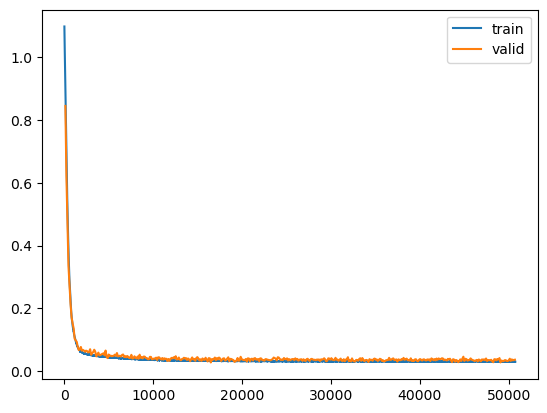

In [19]:
ddpm_learner.recorder.plot_loss()

## Sample generation

Since we implemented sampling in the Callback, we simply can call fastai's built-in `get_preds` function to get our predictions.

In [20]:
preds = ddpm_learner.get_preds()

we are passing a labels vector that looks like `[0,1,2,3,4,5,6,7,8,9,0,1,2,3,4.....]`

/tmp/ipykernel_3947841/2746988596.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wandb.Image(torch.tensor(0.5*preds[0][0]+0.5)).image


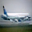

In [21]:
wandb.Image(torch.tensor(0.5*preds[0][0]+0.5)).image

In [22]:
p = preds[0]

In [40]:
p.shape

torch.Size([512, 3, 32, 32])

In [41]:
p.mean(dim=(0,2,3))

TensorImage([ 0.0476,  0.0386, -0.0597])

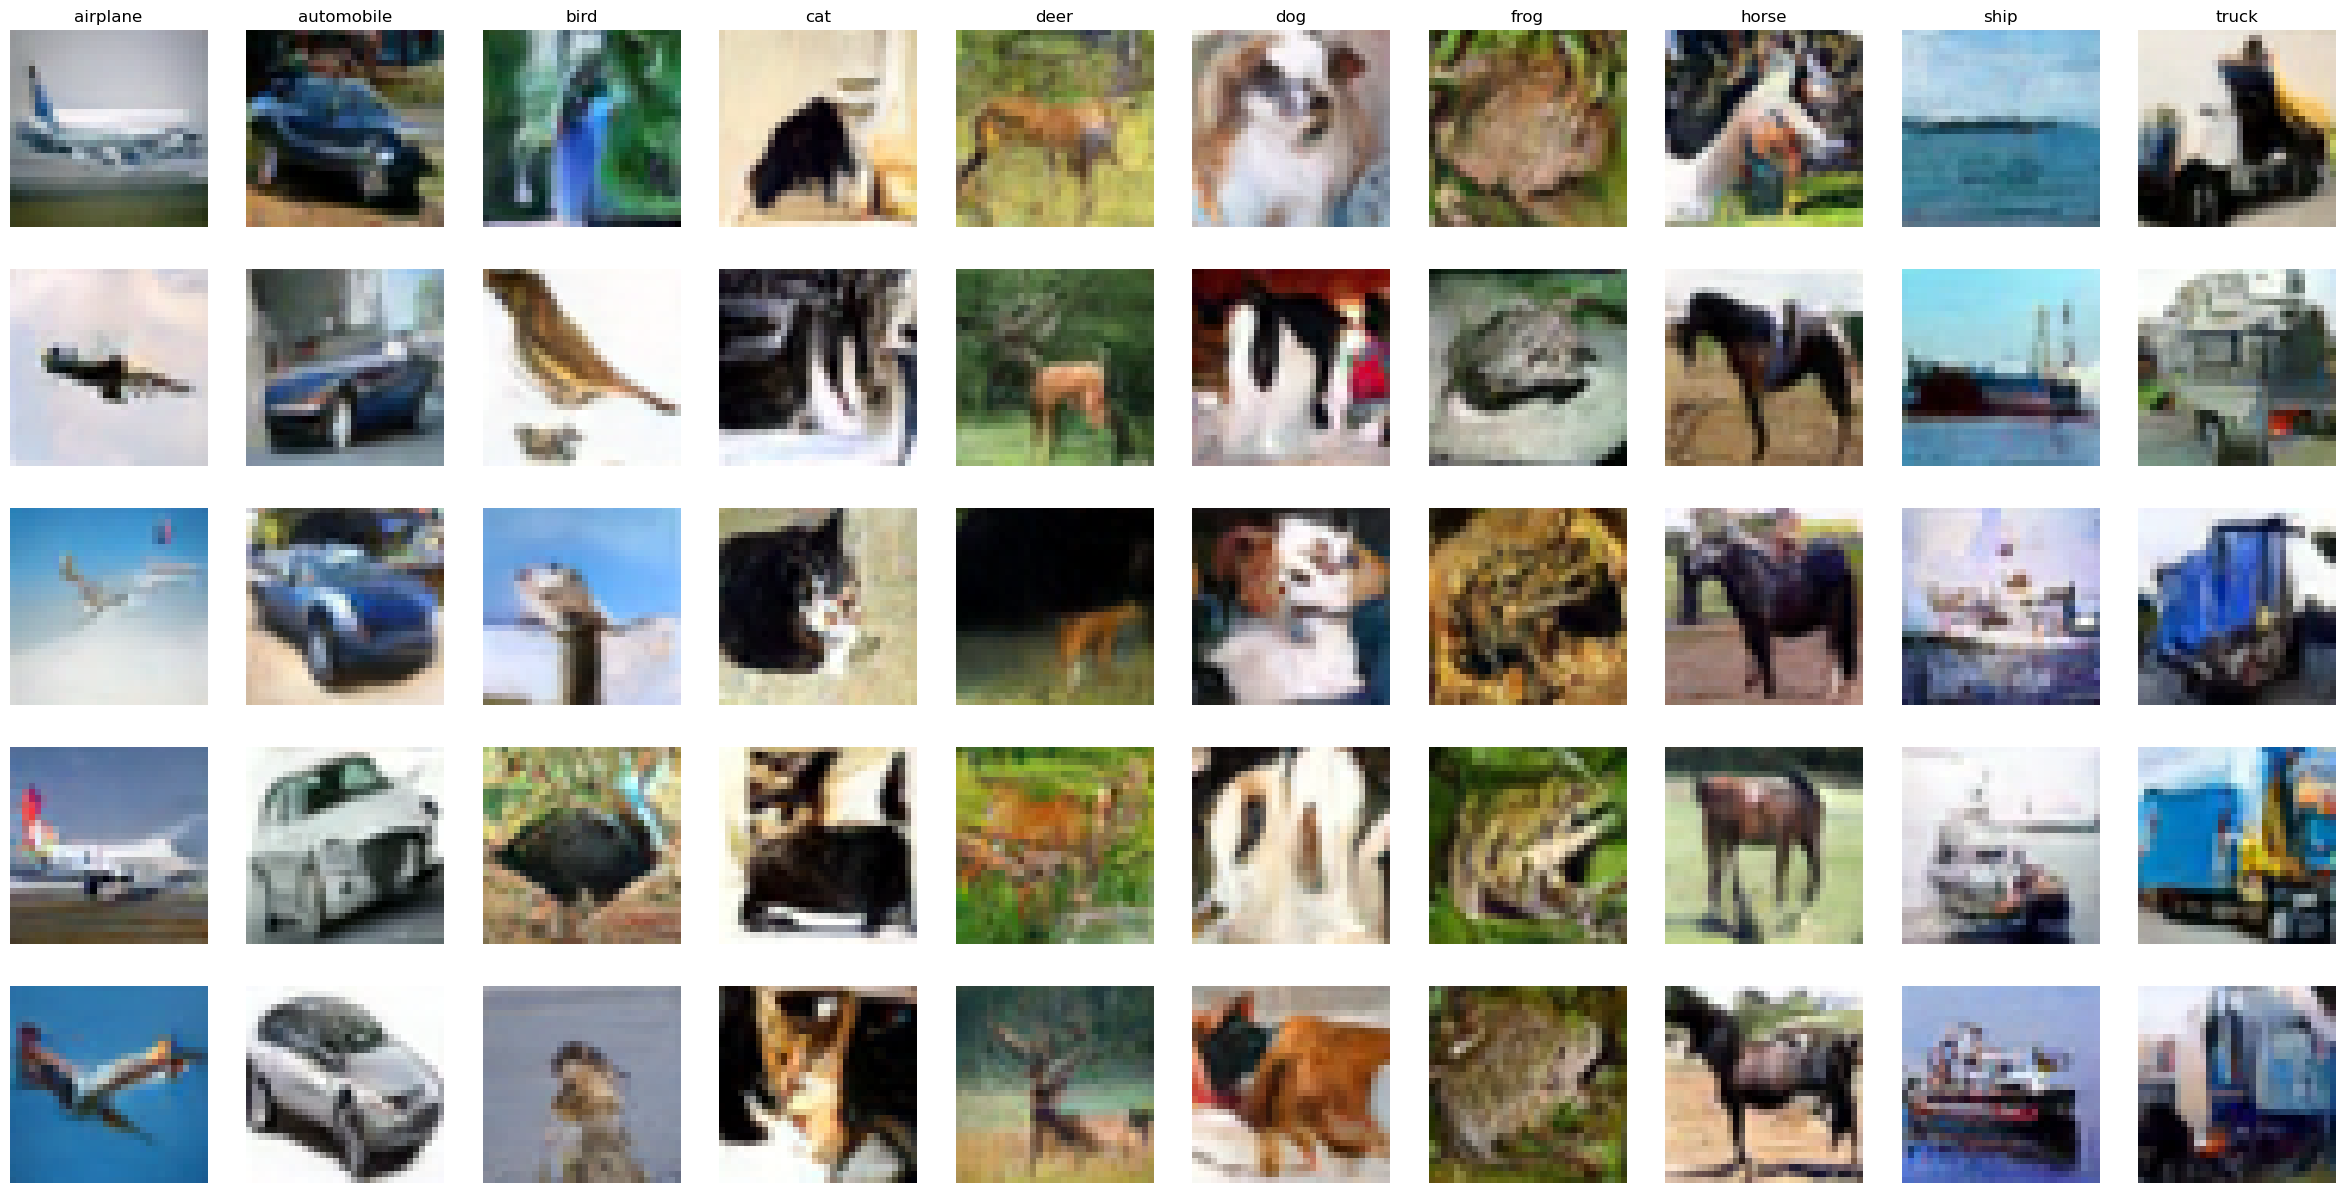

In [23]:
nrows=5
ncols = int(math.ceil(25/10))
axs = subplots(nrows, 10)[1].flat
for i, (pred, ax) in enumerate(zip(preds[0], axs)): 
    ((pred+1)/2).show(ax=ax, title=dls.vocab[i] if i<10 else None)

In [24]:
def log_table(rows=10):
    table = wandb.Table(columns=list(dls.vocab))
    for i, row in enumerate(preds[0].split(len(dls.vocab))):
        if i<rows:
            table.add_data(*[wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in row])
    wandb.log({"pred_table":table})

In [25]:
log_table()
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
mom_0,██▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
raw_loss,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▆▇▆▆▅▆▆▇▆▆█▆▇▇█▇██▁█▆█▆▇▆▅▆▆▅▆▆▄▆▆▆▅▆▆▅▇
valid_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,437.37931


Another useful thing to check is the prediction of the completely denoised image at some timestep. Our sampling takes our prediction of noise in the image but takes only a fraction of it to remove from the noisy image during the iterative process. But we can also try to see the full denoising prediction by fully subtracting out the prediction. Of course, at higher noise levels this will be inaccurate, but at lower noise levels it should be quite accurate.

In [26]:
eps = TensorImage(torch.randn(xb.shape, device=xb.device))
x0 = xb # original images
batch_size = x0.shape[0]
with torch.no_grad():
    t = torch.randint(0, ddpm_learner.conditional_ddpm.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
    alpha_bar_t = ddpm_learner.conditional_ddpm.alpha_bar[t].reshape(-1, 1, 1, 1)
    xt =  torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*eps # noisy images
    x0hat = (xt - torch.sqrt(1-alpha_bar_t)*ddpm_learner.model(xt,t))/torch.sqrt(alpha_bar_t) # predicted denoised images

Timestep 73 is closer to 0 so less noisy but noise is still visible.

In [27]:
np.where((t==73).cpu())[0]

array([], dtype=int64)

Now we can see the original clean image (x0), the noisy image (xt), and the model's attempt to remove the noise (x0hat)

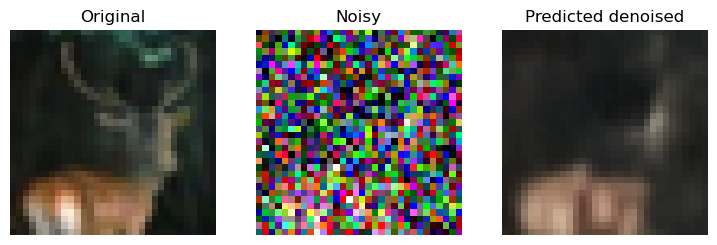

In [28]:
idx = 383
ctxs = get_grid(3,1,3)
ax1 = dls.after_batch.decode((x0,))[0][idx].show(ctx=ctxs[0], title='Original')
ax2 =  dls.after_batch.decode((xt,))[0][idx].show(ctx=ctxs[1], title='Noisy')
ax3 =  dls.after_batch.decode((x0hat,))[0][idx].show(ctx=ctxs[2], title='Predicted denoised')